## Implementing the Multi-channel Variational Autoencoder (MCVAE) for multi-modal disease survival prediction
**Author**: Florence Townend 

Aim of work: investigate whether fusing clinical and neuroimaging using the MCVAE leads to improved performance over uni-modal models and concatenation.

This work implements the Multi-channel variational autoencoder, created by Antelmi et al and found in this github repo: https://github.com/ggbioing/mcvae.


In [16]:
# imports 
import pandas as pd
import numpy as np
from src.mcvae_funcs import *
from src.classification_funcs import run_all_data_inputs_loo
from sklearn import metrics

Specify the paths for the clinical data (complete with classification label) and your imaging modality data (for example, extracted brain volumes).

Clinical dataframe specifications:
- index: study_id
- features: can be a mix of categorical and continuous
- label: some binary classification

Imaging dataframe specifications:
* index: study_id
* features: continuous extracted features from some imaging modality, linked to one of the study_ids in the clinical data

In [7]:
clinical_dataframe_path = "/Users/florencetownend/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Projects/multichannel-VAE-survival-classification/clinical_dataframe.csv"
clinical_df = pd.read_csv(clinical_dataframe_path)
clinical_df.set_index("study_id", inplace=True)

imaging_dataframe_path = "/Users/florencetownend/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Projects/multichannel-VAE-survival-classification/brain_volume.csv"
brainvolume_df = pd.read_csv(imaging_dataframe_path)
brainvolume_df.set_index("study_id", inplace=True)

# specified number of latent dimensions
num_latent_dims = 5


Training the MCVAE first time round with a lot of epochs, so that we can look at the loss logs and choose the best training time.

In [10]:
mcvae1 = MCVAE_instance(clinical_df, brainvolume_df, n_latents=num_latent_dims, n_epochs=2000)
mcvae1.mcvae_prepare_data()
mcvae1.plot_dropouts(plot_flag=False)

...preparing data for MCVAE...
(26, 5)
...fitting MCVAE with 10 latent dimensions and 2000 epochs...
====> Epoch:    0/2000 (0%)	Loss: 974.8675	LL: -966.2373	KL: 8.6302	LL/KL: -111.9600
====> Epoch:   10/2000 (0%)	Loss: 571.2278	LL: -562.0093	KL: 9.2185	LL/KL: -60.9654
====> Epoch:   20/2000 (1%)	Loss: 394.7713	LL: -385.0995	KL: 9.6719	LL/KL: -39.8165
====> Epoch:   30/2000 (2%)	Loss: 319.6001	LL: -309.4580	KL: 10.1421	LL/KL: -30.5122
====> Epoch:   40/2000 (2%)	Loss: 270.4915	LL: -259.8044	KL: 10.6870	LL/KL: -24.3103
====> Epoch:   50/2000 (2%)	Loss: 239.6680	LL: -228.4076	KL: 11.2604	LL/KL: -20.2842
====> Epoch:   60/2000 (3%)	Loss: 202.6783	LL: -190.8179	KL: 11.8604	LL/KL: -16.0887
====> Epoch:   70/2000 (4%)	Loss: 187.8389	LL: -175.3498	KL: 12.4891	LL/KL: -14.0403
====> Epoch:   80/2000 (4%)	Loss: 183.8306	LL: -170.7219	KL: 13.1087	LL/KL: -13.0235
====> Epoch:   90/2000 (4%)	Loss: 149.8694	LL: -136.1846	KL: 13.6848	LL/KL: -9.9515
====> Epoch:  100/2000 (5%)	Loss: 158.4291	LL: -144.

Epoch chosen after early stopping with patience 20                     and tolerance 3 : 1626.
...fitting MCVAE with 5 latent dimensions and 1626 epochs...
====> Epoch:    0/1626 (0%)	Loss: 847.5724	LL: -843.2665	KL: 4.3059	LL/KL: -195.8389
====> Epoch:   10/1626 (1%)	Loss: 606.7869	LL: -602.1470	KL: 4.6399	LL/KL: -129.7755
====> Epoch:   20/1626 (1%)	Loss: 447.9848	LL: -443.0121	KL: 4.9727	LL/KL: -89.0886
====> Epoch:   30/1626 (2%)	Loss: 375.0461	LL: -369.7189	KL: 5.3272	LL/KL: -69.4017
====> Epoch:   40/1626 (2%)	Loss: 280.4250	LL: -274.7147	KL: 5.7103	LL/KL: -48.1085
====> Epoch:   50/1626 (3%)	Loss: 250.7772	LL: -244.6794	KL: 6.0978	LL/KL: -40.1258
====> Epoch:   60/1626 (4%)	Loss: 235.8159	LL: -229.3569	KL: 6.4591	LL/KL: -35.5094
====> Epoch:   70/1626 (4%)	Loss: 228.4020	LL: -221.5483	KL: 6.8537	LL/KL: -32.3252
====> Epoch:   80/1626 (5%)	Loss: 209.1693	LL: -201.9468	KL: 7.2226	LL/KL: -27.9606
====> Epoch:   90/1626 (6%)	Loss: 184.9698	LL: -177.4151	KL: 7.5548	LL/KL: -23.4838
==

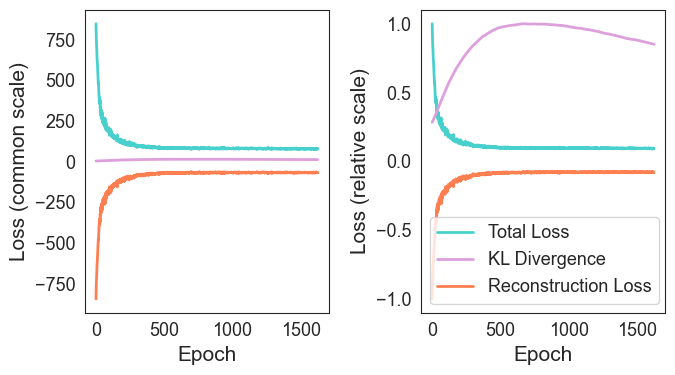

In [11]:
ideal_epoch = early_stopping_tol(tolerance=3, patience=20, loss_logs=mcvae1.big_fit_model.loss['ll'])
mcvae1.n_epochs = ideal_epoch
mcvae1.fit()
mcvae1.plot_loss_own()

Training with leave-one-out protocol with an SVM

Clinical only:
F1: {'Support Vector': 0.6666666666666667}, Accuracy: {'Support Vector': 0.6923076923076923}, AUC: {'Support Vector': 0.36094674556213013}
Brain volume only:
F1: {'Support Vector': 0.5185185185185186}, Accuracy: {'Support Vector': 0.5}, AUC: {'Support Vector': 0.14792899408284022}
Concatenated clinical and brain volume:
F1: {'Support Vector': 0.5185185185185186}, Accuracy: {'Support Vector': 0.5}, AUC: {'Support Vector': 0.13905325443786984}
MCVAE Latent Space:
F1: {'Support Vector': 0.608695652173913}, Accuracy: {'Support Vector': 0.6538461538461539}, AUC: {'Support Vector': 0.21893491124260356}
######## Support Vector ########
clinical vs mcvae: 1.0
bv vs mcvae: 0.4227
concat vs mcvae: 0.3428


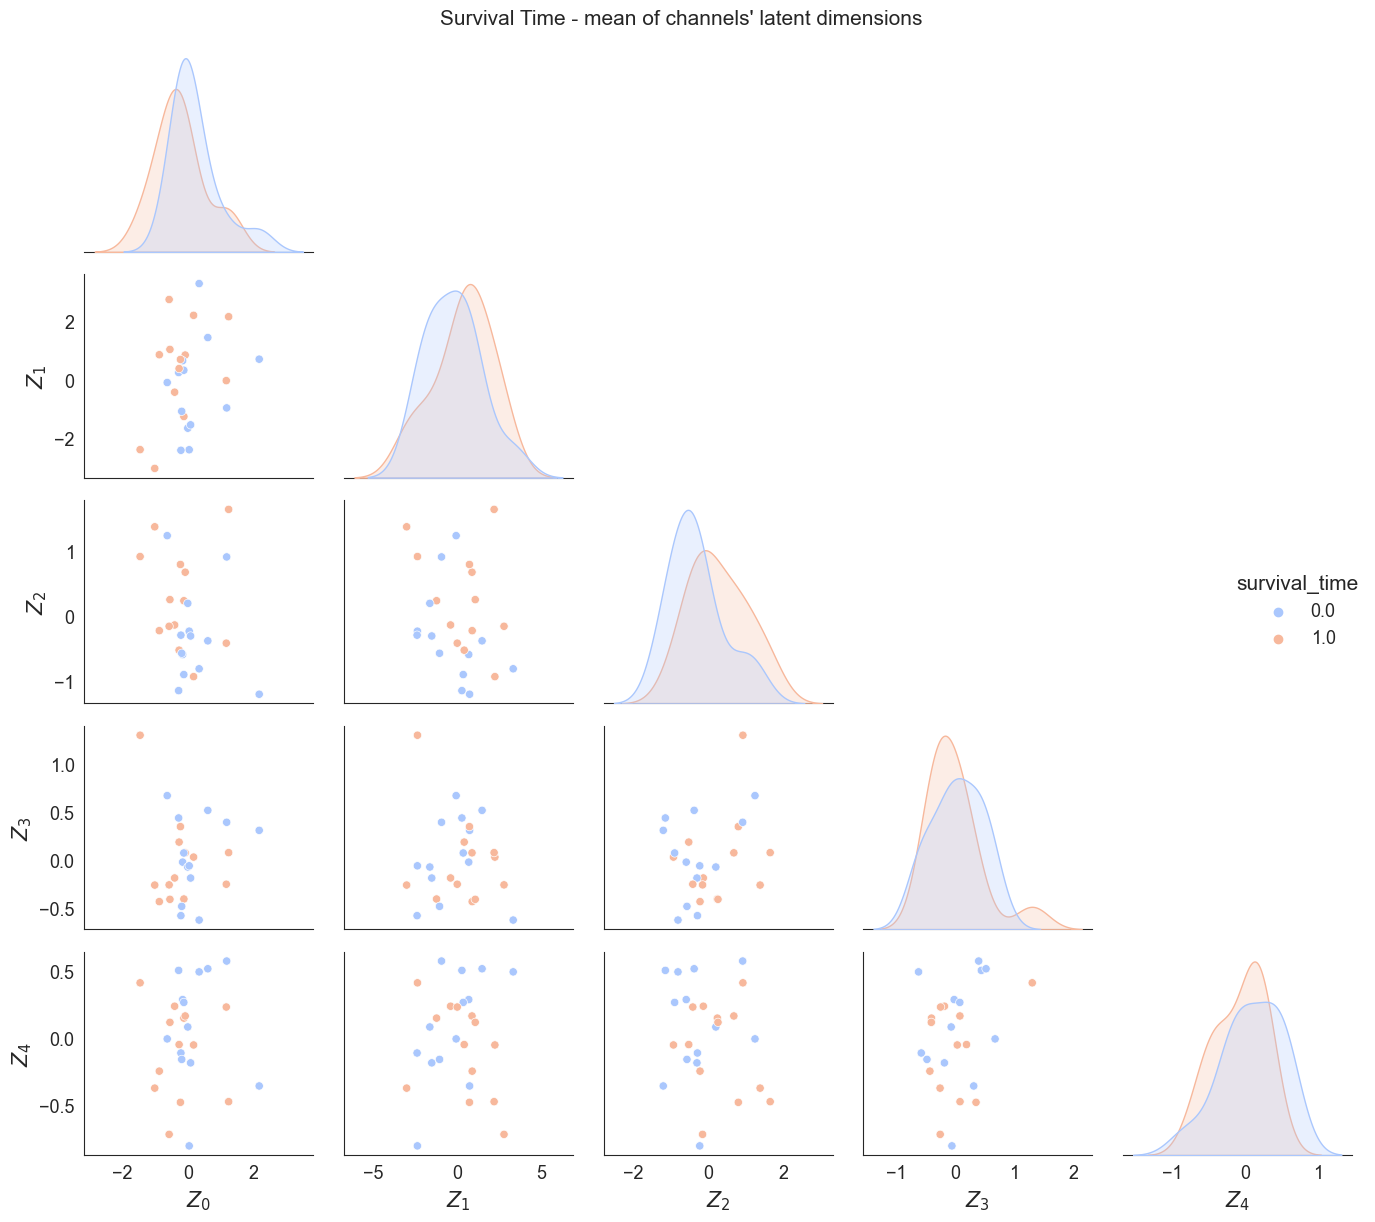

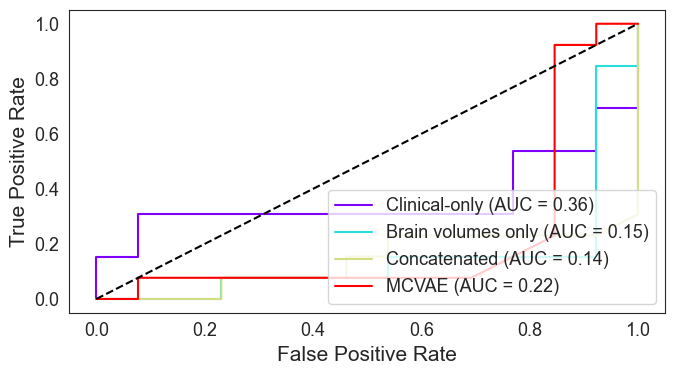

In [18]:
svm_results, [f1s_all, accs_all, aucs_all, 
              preds_all, expecteds_all, probs_all] = run_all_data_inputs_loo(clinical_df, brainvolume_df, mcvae1,
                                                                             path_name = f"mean_latent_space_{num_latent_dims}.png", 
                                                                               sig_test_flag=True)

pd.DataFrame.to_csv(svm_results, f"final_metrics_{num_latent_dims}.csv")

names = ['Clinical-only', 'Brain volumes only', 'Concatenated', 'MCVAE']

fig, ax = plt.subplots()

color = iter(plt.cm.rainbow(np.linspace(0, 1, 4)))

for i, dict_instance in enumerate(probs_all):
    y_scores = dict_instance['Support Vector']
    y_trues = expecteds_all[i]['Support Vector']
    
    fpr, tpr, thresholds = metrics.roc_curve(y_trues, y_scores, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    c = next(color)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot(ax=ax, name=names[i], c=c)

ax.plot([0,1],[0,1],'k--')
plt.tight_layout()
plt.savefig(f"roc_curve_{num_latent_dims}.png",dpi=180)
plt.show()